# Analysis of Meghdadi's EEG dataset
This Jupyter notebook computes 1/f slopes and E/I predictions from resting-state EEG recordings of healthy individuals across different ages and recordings of AD patients included in the Meghdadi's EEG dataset [1].

[1] Meghdadi, A. H., M. Stevanović Karić, M. McConnell, G. Rupp, C. Richard, J. Hamilton, D. Salat, and C. Berka. 2021. "Resting state EEG biomarkers of cognitive decline associated with Alzheimer's disease and mild cognitive impairment." PLoS One 16 (2): e0244180. https://doi.org/10.1371/journal.pone.0244180. 

In [1]:
import numpy as np
import sys,os
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pymp
import pickle
import csv
import pandas as pd
import tools
from sklearn.metrics import r2_score

In [2]:
def polynomial_fit(x,y,Vax,color):
    '''
    Plot a polynomial fit on Vax.
    
    Parameters
    ----------
    x,y: lists, numpy arrays
        Series of data points.
    Vax: matplotlib Axes object
    color: color format
        line color.
    '''
    z1 = np.polyfit(x, y,2)
    p1 = np.poly1d(z1)
    x_sorted = np.sort(x)
    Vax.plot(x_sorted,p1(x_sorted),color = color,linewidth = 4.,alpha = 0.4)

Select between computing 1/f slopes (**'compute'**) or loading slopes from file (**'load'**).

In [3]:
slopes_compute = 'compute'

Data structures to collect power spectra of patients with Alzheimer's disease (AD) and control classes (HC2, HC3).

In [4]:
AD_spectra = [[] for k in range(20)] # 20 EEG channels
HC2_spectra = [[] for k in range(20)]
HC3_spectra = [[] for k in range(20)]

Load EEG power spectrum data from file, sort them in the data structures defined above and normalize power spectra. 

In [5]:
with open('data/PLOSONE2020_DATA_v1.1.csv') as csv_file:
    # Load CSV file
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0: # headers in first row
            # Power spectrum arrays
            spectrum = [[] for k in range(20)]

            # Sort power data (there is one frequency every 30 samples, single
            # electrode data are in the first 20 samples of each block)
            for sample in np.arange(21,1480,30):
                for ch in range(20): # channels
                    spectrum[ch].append(float(row[sample+ch]))

            # Frequencies (Hz)
            fx = np.arange(1,50)

            # Normalization in the (1,40) Hz range
            for ch in range(20):
                spectrum[ch] /= np.mean(spectrum[ch][0:40])

            # Revert log-transform power spectrum
            for ch in range(20):
                spectrum[ch] = np.power(10,np.array(spectrum[ch]))

            # Collect power spectra
            for ch in range(20):
                if row[0] == 'AD':
                    AD_spectra[ch].append(spectrum[ch])
                if row[0] == 'HC2':
                    HC2_spectra[ch].append(spectrum[ch])
                if row[0] == 'HC3':
                    HC3_spectra[ch].append(spectrum[ch])

        # EEG electrode labels
        else:
            ch_names = []
            for sample in np.arange(21,41,1):
                ch_names.append(row[sample][:-2])

        line_count+=1
    print(f'Processed {line_count} lines.')

Processed 394 lines.


Parameters of the algorithm for parameterizing neural power spectra.

In [6]:
fit_parameters = {
    'freq_range_FOOOF_fitting': [1.,40.], # Hz
    'FOOOF_max_n_peaks': 3,
    'FOOOF_peak_width_limits': [2.,50.], # Hz
    'FOOOF_peak_threshold': 1.
}

Either compute slopes using multi-threading (8 threads) or load slopes from file.

In [7]:
if slopes_compute == 'compute':
    # Datasets of slopes defined as shared variables
    AD_slopes = pymp.shared.list([pymp.shared.list([]) for k in range(20)])
    HC2_slopes = pymp.shared.list([pymp.shared.list([]) for k in range(20)])
    HC3_slopes = pymp.shared.list([pymp.shared.list([]) for k in range(20)])
    channels_completed = pymp.shared.list([0])

    # Multi-threading with OpenMP-like functionality
    with pymp.Parallel(8) as p:
        for channel in p.range(0,len(ch_names)):
            # AD
            for spectrum in AD_spectra[channel]:
                # Run the fitting algorithm
                fit_results = tools.power_spectrum_fit(fx,spectrum,fit_parameters)

                if len(fit_results) > 1:
                    # Collect parameters
                    with p.lock:
                        AD_slopes[channel].append(fit_results[0][1])
            # HC2
            for spectrum in HC2_spectra[channel]:
                # Run the fitting algorithm
                fit_results = tools.power_spectrum_fit(fx,spectrum,fit_parameters)

                if len(fit_results) > 1:
                    # Collect parameters
                    with p.lock:
                        HC2_slopes[channel].append(fit_results[0][1])
            # HC3
            for spectrum in HC3_spectra[channel]:
                # Run the fitting algorithm
                fit_results = tools.power_spectrum_fit(fx,spectrum,fit_parameters)

                if len(fit_results) > 1:
                    # Collect parameters
                    with p.lock:
                        HC3_slopes[channel].append(fit_results[0][1])

            # show progress
            with p.lock:
                channels_completed[0]+=1
            print("Computing slopes. Progress: %.0f%% \n" % (
                                            100*(channels_completed[0]/20)))

    # Convert to lists
    AD_slopes_l = [np.array(AD_slopes[ch]) for ch in range(20)]
    HC2_slopes_l = [np.array(HC2_slopes[ch]) for ch in range(20)]
    HC3_slopes_l = [np.array(HC3_slopes[ch]) for ch in range(20)]

    # Create directories to save slopes
    if not os.path.isdir('slopes'):
        os.mkdir('slopes')
    if not os.path.isdir('slopes/Meghdadi_data'):
        os.mkdir('slopes/Meghdadi_data')

    # Save slopes
    pickle.dump(AD_slopes_l,open("slopes/Meghdadi_data/AD_slopes","wb") )
    pickle.dump(HC2_slopes_l,open("slopes/Meghdadi_data/HC2_slopes","wb") )
    pickle.dump(HC3_slopes_l,open("slopes/Meghdadi_data/HC3_slopes","wb") )

# Load slopes from file
else:
    AD_slopes_l = pickle.load(open("slopes/Meghdadi_data/AD_slopes","rb") )
    HC2_slopes_l = pickle.load(open("slopes/Meghdadi_data/HC2_slopes","rb") )
    HC3_slopes_l = pickle.load(open("slopes/Meghdadi_data/HC3_slopes","rb") )

Computing slopes. Progress: 5% 

Computing slopes. Progress: 15% 

Computing slopes. Progress: 20% 

Computing slopes. Progress: 25% 

Computing slopes. Progress: 30% 

Computing slopes. Progress: 35% 

Computing slopes. Progress: 10% 

Computing slopes. Progress: 40% 

Computing slopes. Progress: 45% 

Computing slopes. Progress: 55% 

Computing slopes. Progress: 60% 

Computing slopes. Progress: 50% 

Computing slopes. Progress: 65% 

Computing slopes. Progress: 70% 

Computing slopes. Progress: 75% 

Computing slopes. Progress: 80% 

Computing slopes. Progress: 85% 

Computing slopes. Progress: 90% 

Computing slopes. Progress: 95% 

Computing slopes. Progress: 100% 



Load spectral features and labels of E/I from simulations of the recurrent network model [2].

[2] Martínez-Cañada, P., T. V. Ness, G. T. Einevoll, T. Fellin, and S. Panzeri. 2021. "Computation of the electroencephalogram (EEG) from network models of point neurons." PLoS Comput Biol 17 (4): e1008893. https://doi.org/10.1371/journal.pcbi.1008893.

In [8]:
sp_features = pickle.load(open(
            '../spectral_features/Cavallari_model/g/spectral_features', "rb"),
            encoding='latin1')
sp_labels = pickle.load(open(
            '../spectral_features/Cavallari_model/g/labels', "rb"),
            encoding='latin1')

Select only features of the $\sum{|I|}$ proxy (subsampling every 4th entry, starting with the first position).

In [9]:
sp_features = np.array(sp_features[0::4])
sp_labels = np.array(sp_labels[0::4])

Compute a least-squares polynomial regression model (degree = 2) using the simulation data.

In [10]:
x_reg = []
y_reg = []

# We pick only simulations with v0 = 3 spikes/s
k = np.where(sp_labels[:,0] == 3.0)[0]
# Collect slopes and gE/gI for regression
x_reg.append(sp_features[k,2])
y_reg.append(1./sp_labels[k,1]) # Invert gI/gE
# Construct a polynomial regression model and compute R2
model = np.poly1d(np.polyfit(x_reg[0],y_reg[0], 2))
print("r2_score = %s" % (r2_score( y_reg[0], model(x_reg[0]))))

# Create directories to save the regression model
if not os.path.isdir('../regression_coefficients'):
    os.mkdir('../regression_coefficients')
# Save the regression model
pickle.dump(model,open("../regression_coefficients/poly_regression_model","wb") )

r2_score = 0.7715826122836486


Define properties of figures to plot.

In [11]:
DPI = 300
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10

Create and plot Figure 1.

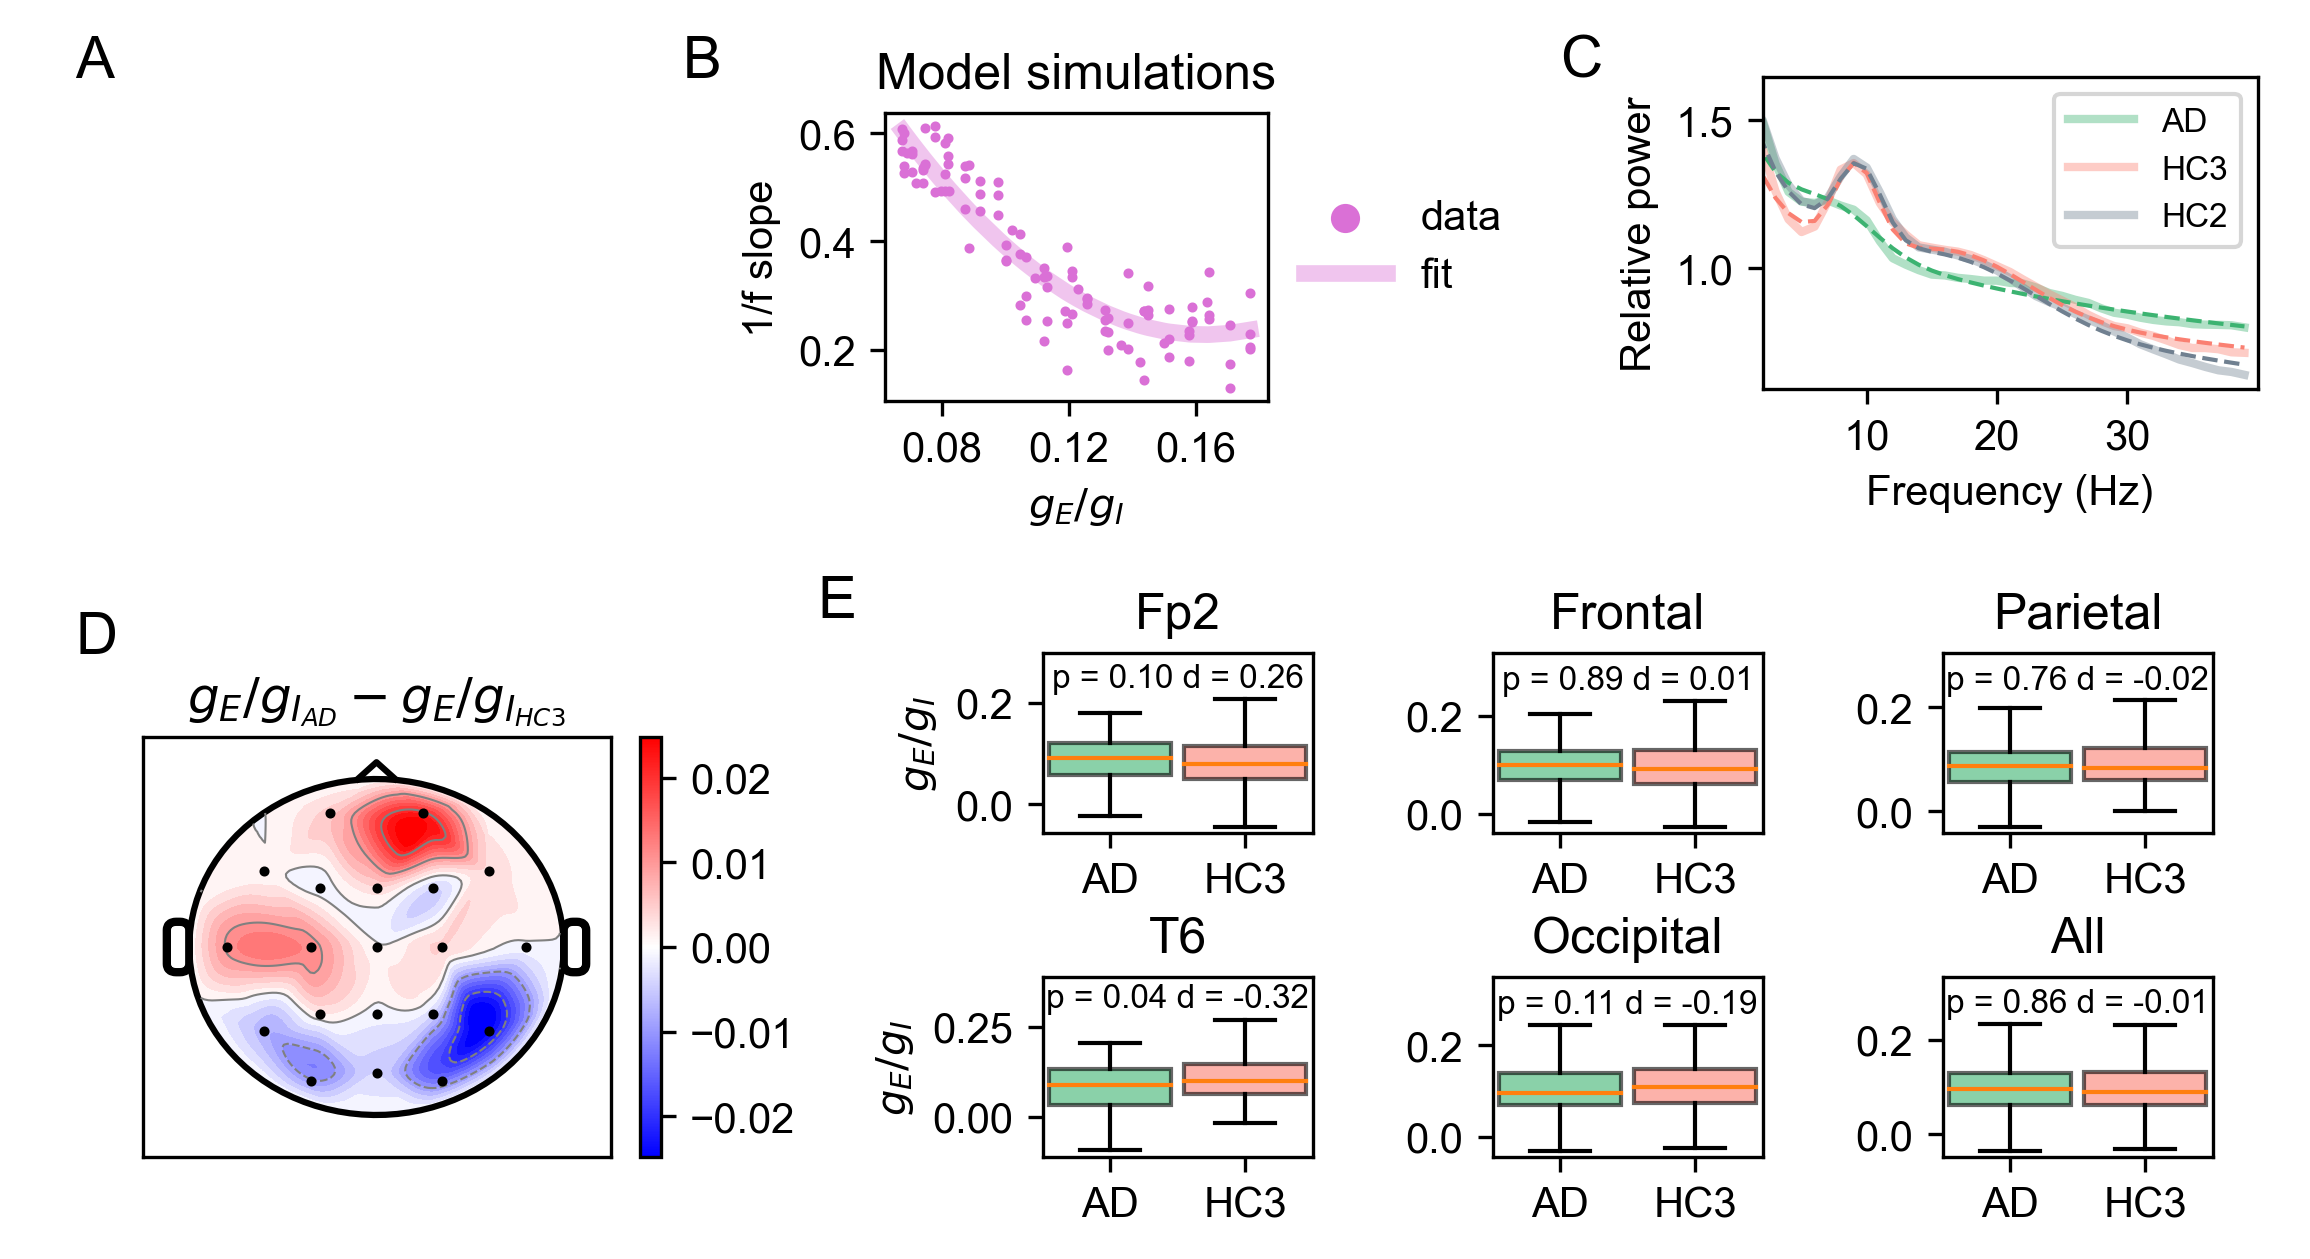

In [12]:
# Create figure 1
fig1 = plt.figure(figsize=[7.5,4], dpi=DPI)

# Labels of the panels
Vax_labels = fig1.add_axes([0.,0.,1.,1.],xticks = [],xticklabels = [],
                                          yticks = [],yticklabels = [],
                                          frameon = False)
Vax_labels.text(0.02,0.96,'A',fontsize = 14)
Vax_labels.text(0.29,0.96,'B',fontsize = 14)
Vax_labels.text(0.68,0.96,'C',fontsize = 14)
Vax_labels.text(0.02,0.48,'D',fontsize = 14)
Vax_labels.text(0.35,0.51,'E',fontsize = 14)

# Plot 1/f slopes vs gE/gI from simulations of the recurrent network model
VaxB = fig1.add_axes([0.38,0.69,0.17,0.24])
VaxB.set_title('Model simulations')
colors = ['orchid']
labels = ['3']
VaxB.scatter(1./sp_labels[k,1],sp_features[k,2],
                s = 2,c = colors[0])

# Polynomial fit
polynomial_fit(1./sp_labels[k,1],sp_features[k,2],
               VaxB,colors[0])

# X-/Y-axis labels
VaxB.set_xlabel(r'$g_E/g_I$')
VaxB.set_ylabel('1/f slope')

# Legend
Vaxlegend = fig1.add_axes([0.56,0.69,0.1,0.2],frameon=False,
                          xticks = [],yticks = [])
Vaxlegend.scatter([],[],color = colors[0],label = 'data')
Vaxlegend.plot([],[],linewidth = 4.,alpha = 0.4,color = colors[0],label = 'fit')
leg = Vaxlegend.legend(loc = 'upper center',frameon = False)
leg.get_frame().set_edgecolor('k')

# X-axis tick labels of gE/gI values
ticks = [0.08,0.12,0.16]
VaxB.set_xticks(ticks)
VaxB.set_xticklabels(ticks)

# Comparison of channel-average power spectra from AD and HC3 groups
VaxC = fig1.add_axes([0.77,0.7,0.22,0.26])
VaxC.set_xlabel('Frequency (Hz)')
VaxC.set_ylabel('Relative power')

# Freq. range
freq_range = [np.where(fx >= fit_parameters['freq_range_FOOOF_fitting'][0])[0][0],
              np.where(fx >= fit_parameters['freq_range_FOOOF_fitting'][1])[0][0]]

# Averaged spectra
avg_AD_spectra = np.median(np.array([
                    np.median(AD_spectra[ch],axis = 0) for ch in range(20)]),
                    axis = 0)
avg_HC3_spectra = np.median(np.array([
                    np.median(HC3_spectra[ch],axis = 0) for ch in range(20)]),
                    axis = 0)
avg_HC2_spectra = np.median(np.array([
                    np.median(HC2_spectra[ch],axis = 0) for ch in range(20)]),
                    axis = 0)

# Spectral fittings
AD_spectrum_fit = tools.power_spectrum_fit(fx,avg_AD_spectra,fit_parameters)
HC3_spectrum_fit = tools.power_spectrum_fit(fx,avg_HC3_spectra,fit_parameters)
HC2_spectrum_fit = tools.power_spectrum_fit(fx,avg_HC2_spectra,fit_parameters)

# Power spectrum
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_AD_spectra[freq_range[0]:freq_range[1]]),
          color = 'mediumseagreen', linewidth = 2.,alpha = 0.4,label = 'AD')
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_HC3_spectra[freq_range[0]:freq_range[1]]),
          color = 'salmon', linewidth = 2.,alpha = 0.4,label = 'HC3')
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_HC2_spectra[freq_range[0]:freq_range[1]]),
          color = 'slategrey', linewidth = 2.,alpha = 0.4,label = 'HC2')

# FOOOF fitting
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(AD_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'mediumseagreen',linestyle='--',linewidth=1.)
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(HC3_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'salmon',linestyle='--',linewidth=1.)
VaxC.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(HC2_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'slategrey',linestyle='--',linewidth=1.)

# legend
VaxC.legend(fontsize = 8, loc = 'upper right')
VaxC.set_xlim([2,40])
VaxC.set_xticks([10,20,30])
VaxC.set_xticklabels(['10','20','30'])

# Topographical representation of differences in E/I
VaxD = fig1.add_axes([0.05,0.06,0.26,0.35])
VaxD.set_yticks([])
VaxD.set_yticklabels([])
VaxD.set_xticks([])
VaxD.set_xticklabels([])
VaxD.set_title(r'$g_E/g_{I_{AD}}-g_E/g_{I_{HC3}}$')

# Head model
tools.plot_simple_head_model(VaxD, 0.4, 0.)

# Limits
VaxD.set_xlim([-0.5,0.5])
VaxD.set_ylim([-0.5,0.5])

# Collect differences in means of E/I
diff_g = [np.mean(model(AD_slopes_l[ch])) -\
          np.mean(model(HC3_slopes_l[ch])) for ch in range(20)]
vmin = -np.max(np.abs(diff_g))
vmax = np.max(np.abs(diff_g))

# Brain plot
tools.plot_EEG(fig1,VaxD, diff_g, 0.4, 0,vmin,vmax)

# Pooling of E/I predictions across subsets of brain regions
VaxE1 = fig1.add_axes([0.45,0.33,0.12,0.15])
VaxE2 = fig1.add_axes([0.65,0.33,0.12,0.15])
VaxE3 = fig1.add_axes([0.85,0.33,0.12,0.15])
VaxE4 = fig1.add_axes([0.45,0.06,0.12,0.15])
VaxE5 = fig1.add_axes([0.65,0.06,0.12,0.15])
VaxE6 = fig1.add_axes([0.85,0.06,0.12,0.15])
all_VaxE = [VaxE1,VaxE2,VaxE3,VaxE4,VaxE5,VaxE6]

VaxE1.set_title('Fp2')
VaxE2.set_title('Frontal')
VaxE3.set_title('Parietal')
VaxE4.set_title('T6')
VaxE5.set_title('Occipital')
VaxE6.set_title('All')

VaxE1.set_ylabel(r'$g_E/g_I$')
VaxE4.set_ylabel(r'$g_E/g_I$')

for gg in range(6):
    # Prefrontal
    if gg == 0:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'Fp2')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'Fp2')[0][0]]]
    # Frontal
    if gg == 1:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'F3')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F4')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F7')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F8')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'Fz')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'F3')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F4')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F7')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F8')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'Fz')[0][0]]]
    # Parietal
    if gg == 2:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'P3')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'P4')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'Pz')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'P3')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'P4')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'Pz')[0][0]]]
    # T6
    if gg == 3:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'T6')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'T6')[0][0]]]

    # Occipital
    if gg == 4:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'O1')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'O2')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'O1')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'O2')[0][0]]]

    # All
    if gg == 5:
        AD_subset = AD_slopes_l
        HC3_subset = HC3_slopes_l

    # E/I predictions
    AD_preds = model(np.hstack(np.array(AD_subset)))
    HC3_preds = model(np.hstack(np.array(HC3_subset)))

    # Boxplots of E/I predictions
    bplot1 = all_VaxE[gg].boxplot(x = AD_preds, positions = [0],widths = [0.9],
                                patch_artist=True,showfliers=False)
    bplot2 = all_VaxE[gg].boxplot(x = HC3_preds, positions = [1],widths = [0.9],
                                patch_artist=True,showfliers=False)

    # Colors
    for patch in bplot1['boxes']:
        patch.set_facecolor('mediumseagreen')
        patch.set_alpha(0.6)
    for patch in bplot2['boxes']:
        patch.set_facecolor('salmon')
        patch.set_alpha(0.6)

    # Labels
    all_VaxE[gg].set_xticks([0,1])
    all_VaxE[gg].set_xticklabels(['AD','HC3'])

    # Statistical test
    tools.t_test(AD_preds,HC3_preds,all_VaxE[gg],8)
    ylim = all_VaxE[gg].get_ylim()
    all_VaxE[gg].set_ylim([ylim[0],ylim[1]*1.35])

Create and plot supplementary figure 1.

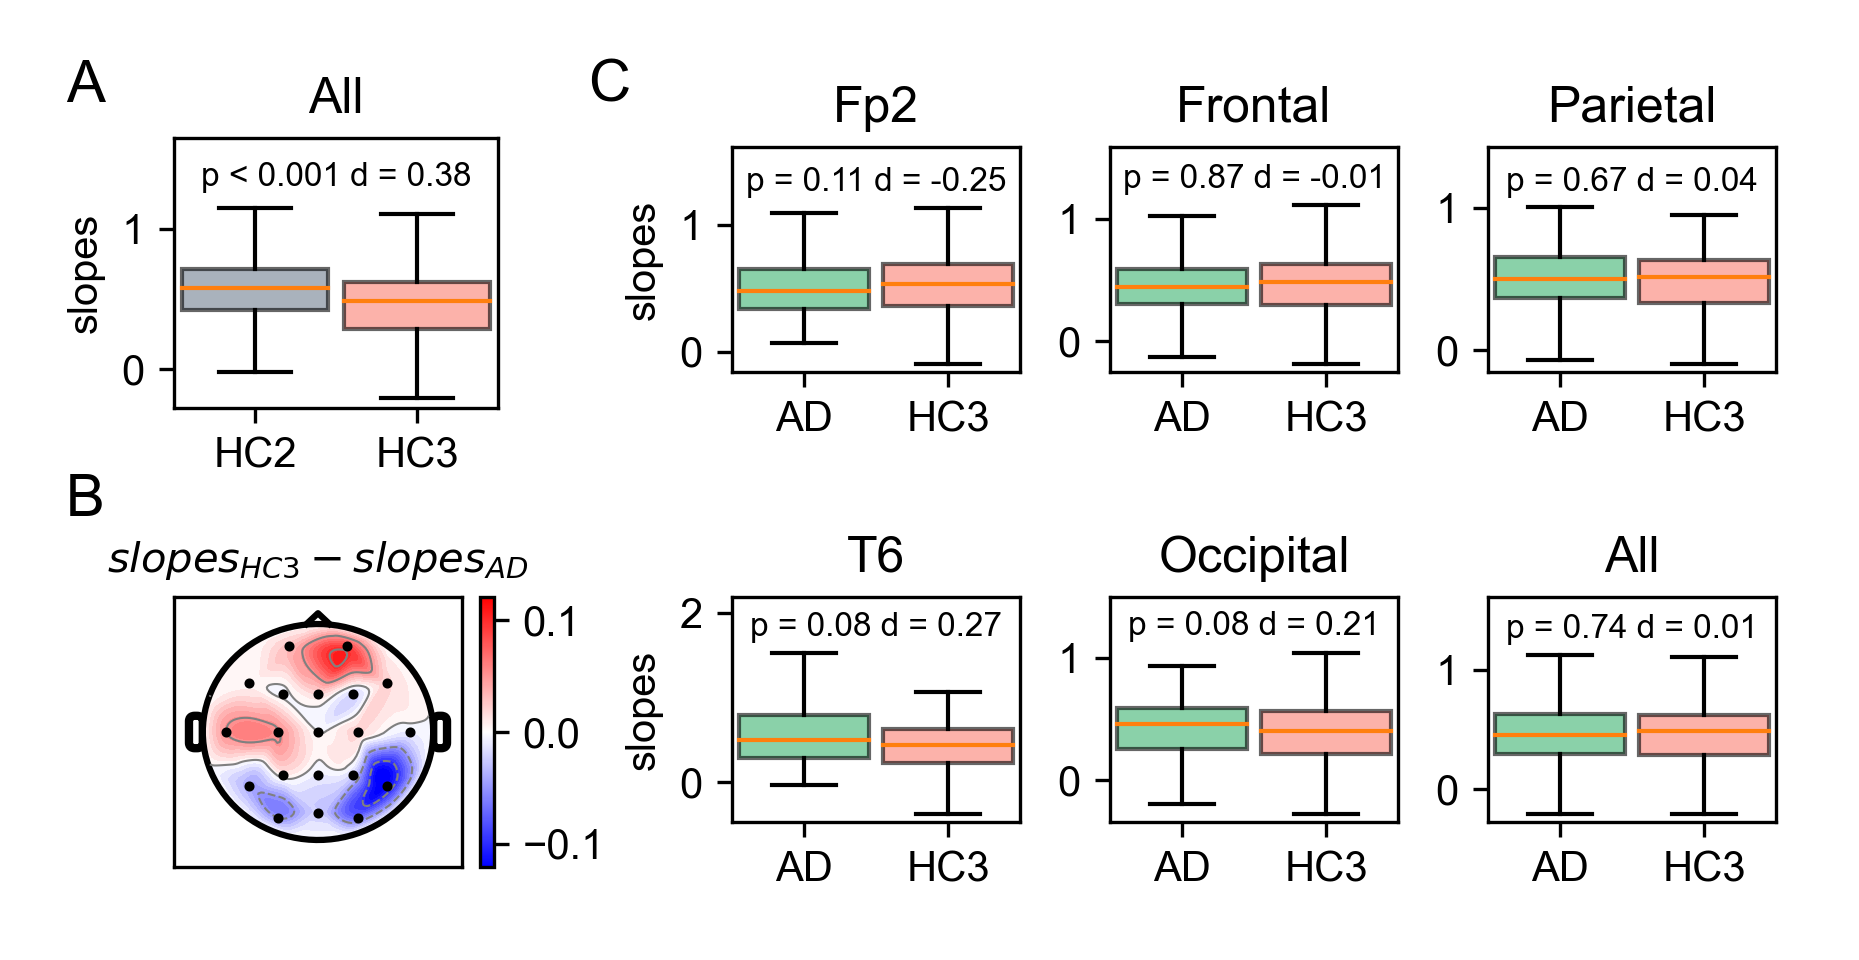

In [13]:
figsup1 = plt.figure(figsize=[6,3], dpi=DPI)

# Labels of the panels
Vax_labels = figsup1.add_axes([0.,0.,1.,1.],xticks = [],xticklabels = [],
                                          yticks = [],yticklabels = [],
                                          frameon = False)
Vax_labels.text(0.02,0.92,'A',fontsize = 14)
Vax_labels.text(0.02,0.46,'B',fontsize = 14)
Vax_labels.text(0.31,0.92,'C',fontsize = 14)

# Slopes of HC2 vs HC3
VaxA = figsup1.add_axes([0.08,0.58,0.18,0.3])
VaxA.set_title('All')
VaxA.set_ylabel('slopes')

# Boxplots
bplot1 = VaxA.boxplot(x = np.hstack(np.array(HC2_slopes_l)),
                            positions = [0],widths = [0.9],
                            patch_artist=True,showfliers=False)
bplot2 = VaxA.boxplot(x = np.hstack(np.array(HC3_slopes_l)),
                            positions = [1],widths = [0.9],
                            patch_artist=True,showfliers=False)

# Colors
for patch in bplot1['boxes']:
    patch.set_facecolor('slategrey')
    patch.set_alpha(0.6)
for patch in bplot2['boxes']:
    patch.set_facecolor('salmon')
    patch.set_alpha(0.6)

# Labels
VaxA.set_xticks([0,1])
VaxA.set_xticklabels(['HC2','HC3'])

# Statistical test
tools.t_test(np.hstack(np.array(HC2_slopes_l)),
             np.hstack(np.array(HC3_slopes_l)),VaxA,8)
ylim = VaxA.get_ylim()
VaxA.set_ylim([ylim[0],ylim[1]*1.35])

# Pooling of slopes across subsets of brain regions
VaxC1 = figsup1.add_axes([0.39,0.62,0.16,0.25])
VaxC2 = figsup1.add_axes([0.6,0.62,0.16,0.25])
VaxC3 = figsup1.add_axes([0.81,0.62,0.16,0.25])
VaxC4 = figsup1.add_axes([0.39,0.12,0.16,0.25])
VaxC5 = figsup1.add_axes([0.6,0.12,0.16,0.25])
VaxC6 = figsup1.add_axes([0.81,0.12,0.16,0.25])
all_VaxC = [VaxC1,VaxC2,VaxC3,VaxC4,VaxC5,VaxC6]

VaxC1.set_title('Fp2')
VaxC2.set_title('Frontal')
VaxC3.set_title('Parietal')
VaxC4.set_title('T6')
VaxC5.set_title('Occipital')
VaxC6.set_title('All')

VaxC1.set_ylabel('slopes')
VaxC4.set_ylabel('slopes')

for gg in range(6):
    # Prefrontal
    if gg == 0:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'Fp2')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'Fp2')[0][0]]]
    # Frontal
    if gg == 1:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'F3')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F4')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F7')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'F8')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'Fz')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'F3')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F4')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F7')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'F8')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'Fz')[0][0]]]
    # Parietal
    if gg == 2:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'P3')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'P4')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'Pz')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'P3')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'P4')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'Pz')[0][0]]]
    # T6
    if gg == 3:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'T6')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'T6')[0][0]]]

    # Occipital
    if gg == 4:
        AD_subset = [AD_slopes_l[np.where(np.array(ch_names) == 'O1')[0][0]],
                     AD_slopes_l[np.where(np.array(ch_names) == 'O2')[0][0]]]
        HC3_subset = [HC3_slopes_l[np.where(np.array(ch_names) == 'O1')[0][0]],
                      HC3_slopes_l[np.where(np.array(ch_names) == 'O2')[0][0]]]

    # All
    if gg == 5:
        AD_subset = AD_slopes_l
        HC3_subset = HC3_slopes_l

    # Boxplots of slopes
    bplot1 = all_VaxC[gg].boxplot(x = np.hstack(np.array(AD_subset)),
                                positions = [0],widths = [0.9],
                                patch_artist=True,showfliers=False)
    bplot2 = all_VaxC[gg].boxplot(x = np.hstack(np.array(HC3_subset)),
                                positions = [1],widths = [0.9],
                                patch_artist=True,showfliers=False)

    # Colors
    for patch in bplot1['boxes']:
        patch.set_facecolor('mediumseagreen')
        patch.set_alpha(0.6)
    for patch in bplot2['boxes']:
        patch.set_facecolor('salmon')
        patch.set_alpha(0.6)

    # Labels
    all_VaxC[gg].set_xticks([0,1])
    all_VaxC[gg].set_xticklabels(['AD','HC3'])

    # Statistical test
    tools.t_test(np.hstack(np.array(AD_subset)),
                 np.hstack(np.array(HC3_subset)),all_VaxC[gg],8)
    ylim = all_VaxC[gg].get_ylim()
    all_VaxC[gg].set_ylim([ylim[0],ylim[1]*1.35])

# Topographical representation of differences in slopes
VaxB = figsup1.add_axes([0.08,0.07,0.2,0.3])
VaxB.set_yticks([])
VaxB.set_yticklabels([])
VaxB.set_xticks([])
VaxB.set_xticklabels([])
VaxB.set_title(r'$slopes_{HC3}-slopes_{AD}$',fontsize = 10)
# Head model
tools.plot_simple_head_model(VaxB, 0.4, 0.)

# Limits
VaxB.set_xlim([-0.5,0.5])
VaxB.set_ylim([-0.5,0.5])

# Collect differences in means of slopes
diff_slopes = [np.mean(HC3_slopes_l[ch]) -\
               np.mean(AD_slopes_l[ch]) for ch in range(20)]
vmin = -np.max(np.abs(diff_slopes))
vmax = np.max(np.abs(diff_slopes))

# Brain plot
tools.plot_EEG(figsup1,VaxB, diff_slopes, 0.4, 0,vmin,vmax)